In [1]:
import tensorflow as tf

2024-04-08 17:23:40.352258: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Preprocessing
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255,
    validation_split = 0.15,
    rotation_range=20,          # 随机旋转范围
    width_shift_range=0.1,      # 随机水平平移范围
    height_shift_range=0.1,     # 随机垂直平移范围
    shear_range=0.2,            # 剪切强度
    zoom_range=0.2,             # 缩放范围
    fill_mode='nearest'         # 填充模式
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = "car-classification-data/train"

In [3]:
batch_size = 16
               
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    classes = ['MPV','SUV','sedan','hatchback','minibus','pickup','sports'],
    shuffle = True,
    seed=13,
    subset="training"
)

valid_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes = ['MPV','SUV','sedan','hatchback','minibus','pickup','sports'],
    shuffle = False,
    seed=13,
    subset="validation"
)

Found 29896 images belonging to 7 classes.
Found 5272 images belonging to 7 classes.


In [4]:
classes = train_generator.class_indices
classes_index = dict((v,k) for k,v in classes.items())
img = train_generator.filepaths

# Get a batch from the generator
x_batch, y_batch = next(train_generator)
print(classes_index)
print(x_batch.shape)
print(y_batch.shape)

{0: 'MPV', 1: 'SUV', 2: 'sedan', 3: 'hatchback', 4: 'minibus', 5: 'pickup', 6: 'sports'}
(16, 224, 224, 3)
(16, 7)


In [5]:
from PIL import Image

Image_path = img[0]
Image = Image.open(Image_path)
width,height = Image.size
channels = len(Image.getbands())
print(width,height,channels)

800 567 3


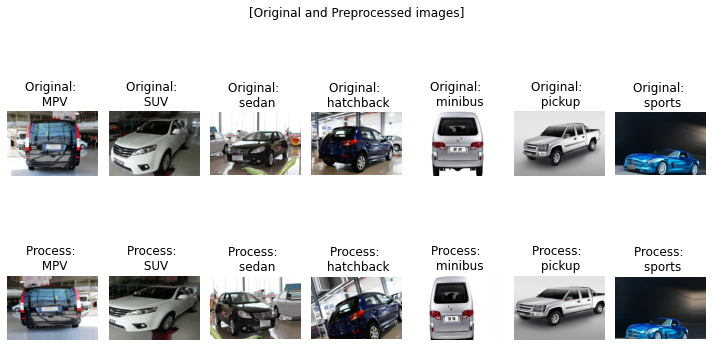

In [17]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os
import random
from keras.preprocessing.image import img_to_array, load_img

selected_images = []

for class_name in classes_index.values():
    class_path = os.path.join(train_set, str(class_name))
    random_image = random.choice(os.listdir(class_path))
    selected_images.append(os.path.join(class_path, random_image))

rows, cols = 2, len(classes)
fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

for i, img_path in enumerate(selected_images, 1):
    class_name = os.path.basename(os.path.dirname(img_path))
    matching_keys = [str(key) for key in classes_index.keys() if str(key).lower() == str(class_name).lower()]
    
    # Load and preprocess the original image
    img_original = load_img(img_path)
    img_array_original = img_to_array(img_original)
    
    img_preprocessed = train_datagen.random_transform(img_array_original)
    
    plt.subplot(rows, cols, i)
    plt.imshow(image.array_to_img(img_array_original))
    plt.title(f"Original: \n {class_name}")
    plt.axis('off')
    
    plt.subplot(rows, cols, i + cols)
    plt.imshow(image.array_to_img(img_preprocessed))
    plt.title(f"Process: \n {class_name}")
    plt.axis('off')

fig.suptitle('[Original and Preprocessed images]')
plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras import layers, models

class ChannelAttention(layers.Layer):
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc = self.build_fc(channel,reduction)
        self.softmax = layers.Activation('softmax')
        
    def build_fc(self, channel, reduction):
        input_tensor = layers.Input(shape=(channel,))
        x = layers.Dense(channel // reduction, use_bias=False)(input_tensor)
        x = layers.ReLU()(x)
        x = layers.Dense(channel, use_bias=False)(x)
        return models.Model(inputs=input_tensor, outputs=x)

    def call(self, x):
        y1 = self.avg_pool(x)
        y1 = tf.expand_dims(tf.expand_dims(self.fc(y1), 1), 1)

        y2 = self.max_pool(x)
        y2 = tf.expand_dims(tf.expand_dims(self.fc(y2), 1), 1)

        y = self.softmax(y1 + y2)
        return x + x * y

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=3):
        super(SpatialAttention, self).__init__()
        assert kernel_size % 2 == 1, "kernel_size = {}".format(kernel_size)
        padding = (kernel_size - 1) // 2
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, padding='same', activation='softmax')

    def call(self, x):
        mask = self.conv(x)
        return x + x * mask

In [8]:
from keras import backend as K

def accuracy(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    correct_predictions = K.equal(y_true, y_pred)
    return K.mean(K.cast(correct_predictions, K.floatx()))

In [9]:
def weighted_categorical_crossentropy(y_true, y_pred, weights):
    # Convert weights to tensor
    weights_tensor = tf.convert_to_tensor(weights, dtype=tf.float32)
    # Apply weights to the cross-entropy loss
    weighted_losses = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=weights_tensor)
    # Take the mean over all examples
    loss = tf.reduce_mean(weighted_losses)
    return loss

In [10]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [11]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
     
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [12]:
# img_batch = K.zeros(shape=(8, 224, 224, 3), dtype='float32')
# Wavelet(img_batch)[0].shape

# DWAN model

In [13]:
from tensorflow.keras.layers import ReLU, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Reshape, concatenate
from keras.layers import Lambda
from keras.initializers import he_normal
from keras import regularizers
from tensorflow.keras.models import Model

def build_branch(input_tensor, filters, reduction=4):
    r = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(input_tensor)
    branch = layers.Conv2D(filters[0], kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
    branch = layers.BatchNormalization()(branch)
    branch = layers.Conv2D(filters[1], kernel_size=1, activation='relu', padding='same')(branch)
    branch = r + layers.BatchNormalization()(branch)
    branch = ChannelAttention(filters[2], reduction=reduction)(branch)
    return branch


def DWAN(num_classes, reduction=4, spatial_kernel_size=3):
    input_shape = (224, 224, 3)
    input_ = layers.Input(input_shape, name='input')
    wavelet = layers.Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

    branch1 = build_branch(input_l1, [32, 64, 64], reduction=reduction)
    branch2 = build_branch(input_l2, [64, 128, 128], reduction=reduction)
    branch3 = build_branch(input_l3, [128, 256, 256], reduction=reduction)
    branch4 = build_branch(input_l4, [128, 256, 256], reduction=reduction)

    conv_a = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', name='conv_1',
                           kernel_initializer=he_normal())(branch1)
    norm_a = layers.BatchNormalization()(conv_a)
    concat_branches1_2 = layers.concatenate([norm_a, branch2])

    conv_b = layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2)
    norm_b = layers.BatchNormalization()(conv_b)
    concat_branches1_2_3 = layers.concatenate([norm_b, branch3])

    conv_c = layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2_3', activation='relu',
                           kernel_initializer=he_normal())(concat_branches1_2_3)
    norm_c = layers.BatchNormalization()(conv_c)
    concat_branches1_2_3_4 = layers.concatenate([norm_c, branch4])

    common_conv = layers.Conv2D(256, kernel_size=3, activation='relu', kernel_initializer=he_normal())(
        concat_branches1_2_3_4)
    common_norm = layers.BatchNormalization()(common_conv)

    spatial = SpatialAttention(kernel_size=spatial_kernel_size)(common_norm)

    global_avg_pooling = layers.GlobalAveragePooling2D()(spatial)

    output = layers.Dense(num_classes, activation='softmax')(global_avg_pooling)

    model = models.Model(inputs=input_, outputs=output)
    return model


DWAN_model = DWAN(num_classes=7)

DWAN_model.summary()

2024-04-08 17:23:45.580084: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-04-08 17:23:45.622515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.77GiB deviceMemoryBandwidth: 707.88GiB/s
2024-04-08 17:23:45.622538: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-08 17:23:45.626726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-08 17:23:45.626780: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-08 17:23:45.627620: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuff

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 112, 112, 12 0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 3488        wavelet[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [14]:
lr=0.0005
class_weights = [0.7, 0.8, 0.8, 0.7, 0.9, 1.7, 0.7]

DWAN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=lambda y_true, y_pred: weighted_categorical_crossentropy(y_true,y_pred,class_weights),
    metrics=['accuracy']
)

# Train the model using the data generators
history = DWAN_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
)

2024-04-08 17:23:47.105324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-04-08 17:23:47.123855: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2500000000 Hz


Epoch 1/30


2024-04-08 17:23:50.545308: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-04-08 17:23:51.311731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-04-08 17:23:52.211864: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-08 17:23:52.843604: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-08 17:23:52.919169: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1869/1869 [==============================] - 580s 307ms/step - loss: 0.7210 - accuracy: 0.2958 - val_loss: 0.7226 - val_accuracy: 0.2862
Epoch 2/30
1869/1869 [==============================] - 571s 305ms/step - loss: 0.7116 - accuracy: 0.3719 - val_loss: 0.7080 - val_accuracy: 0.3892
Epoch 3/30
1869/1869 [==============================] - 569s 305ms/step - loss: 0.7037 - accuracy: 0.4338 - val_loss: 0.7081 - val_accuracy: 0.3873
Epoch 4/30
1869/1869 [==============================] - 567s 304ms/step - loss: 0.6976 - accuracy: 0.4848 - val_loss: 0.7063 - val_accuracy: 0.4200
Epoch 5/30
1869/1869 [==============================] - 566s 303ms/step - loss: 0.6924 - accuracy: 0.5262 - val_loss: 0.6996 - val_accuracy: 0.4640
Epoch 6/30
1869/1869 [==============================] - 571s 306ms/step - loss: 0.6885 - accuracy: 0.5566 - val_loss: 0.6949 - val_accuracy: 0.4989
Epoch 7/30
1869/1869 [==============================] - 569s 305ms/step - loss: 0.6855 - accuracy: 0.5801 - val_loss: 0.688

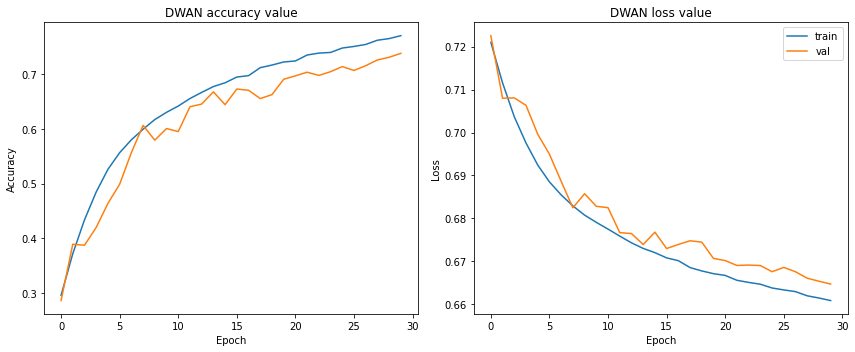

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("DWAN accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("DWAN loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()